In [1]:
import yaml
import os

import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

from matplotlib import colormaps

plt.style.use("../resources/paper.mplstyle")

# TL;DR: Basic reading

Particles are saved at 24 stage across the development.
Right now we will just read one of them in and plot the shower front at that point in space only.
This is very important as there is a non-trivial transform from the `x` and `y` values saved in the file to position in real space.

In [2]:
basedir = f"{os.environ["HOME"]}/Downloads/28507841"
particledir = f"{basedir}/particles5/"
akf = ak.from_parquet(f"{particledir}/particles.parquet")

In [3]:
with open(f"{particledir}/config.yaml") as f:
    config = yaml.safe_load(f)
    
center = np.array(config["plane"]["center"])
zhat = np.array(config["plane"]["normal"])
xhat = np.array(config["x-axis"])
yhat = np.array(config["y-axis"])

mat = np.array([xhat, yhat, zhat])

In [4]:
xyzs = np.zeros((3, len(akf)))

for idx, (x, y) in enumerate(zip(akf["x"], akf["y"])):
    xyz = np.array([x, y, 0.0])
    xyzs[:, idx] = np.matmul(mat, xyz) + center

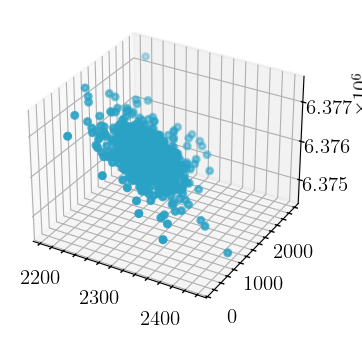

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xyzs[0, :], xyzs[1, :], xyzs[2, :])

plt.show()

# Looking at shower development in time

## Warning: Saving this will take several minutes to run!!

Now, I will iterate over all stages of the shower so that we can try and see the front develop.
Additionally, we will use the `time` field to color the particles.



In [6]:
particledirs = [f"{basedir}/particles{idx}" for idx in range(1, 24)] + [f"{basedir}/particles"]

tmin, tmax = np.inf, -np.inf
for particledir in particledirs:
    akf = ak.from_parquet(f"{particledir}/particles.parquet")
    tmin = min(tmin, np.min(akf["time"]))
    tmax = max(tmax, np.max(akf["time"]))

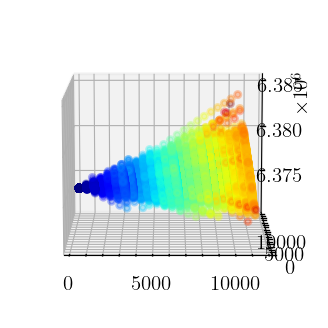

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
cmap = colormaps.get_cmap("jet")

for particledir in particledirs:
    akf = ak.from_parquet(f"{particledir}/particles.parquet")
    
    with open(f"{particledir}/config.yaml") as f:
        config = yaml.safe_load(f)
    center = np.array(config["plane"]["center"])
    zhat = np.array(config["plane"]["normal"])
    xhat = np.array(config["x-axis"])
    yhat = np.array(config["y-axis"])

    mat = np.array([xhat, yhat, zhat])
    
    xyzs = np.zeros((3, len(akf)))

    for idx, (x, y) in enumerate(zip(akf["x"], akf["y"])):
        xyz = np.array([x, y, 0.0])
        xyzs[:, idx] = np.matmul(mat, xyz) + center
    
    ax.scatter(
        xyzs[0, :],
        xyzs[1, :],
        xyzs[2, :],
        color=cmap((akf["time"] - tmin) / (tmax - tmin)),
        alpha=0.3
    )

ax.view_init(elev=10., azim=270.0)

# plt.savefig("../figures/shower_scatter.png")
plt.show()

# More details about the what's inside the file.

In addition to the `x`, `y`, and `time` fields, there are several other pieces of information contained in the file.

- `shower`: Index of the shower the particle came from. We are only doing one shower per file so this should always be 0
- `pdg`: Integer from the [Particle Data Group Monte Carlo Numbering Scheme](https://pdg.lbl.gov/2025/reviews/rpp2024-rev-monte-carlo-numbering.pdf). Common ones include:
    - 11: $e^{-}$
    - -11: $e^{+}$
    - 22: $\gamma$
    - 13: $\mu^{-}$
    - -13: $\mu^{+}$
- `kinetic_energy`: Kinetic energy of the particle in GeV
- `nx`, `ny`, `nz`: Components of the particle's direction vector. I think that these also have to be transformed in the same way that `x` and `y` do, but I have not confirmed this. I have never used these so please do diagnostics and sanity checks when using.
- `weight`: Weight to apply to particle when thinning has been applied. We are not doing a very agressive thinning so these should be relatively small.

In [16]:
akf.fields

['shower',
 'pdg',
 'kinetic_energy',
 'x',
 'y',
 'nx',
 'ny',
 'nz',
 'time',
 'weight']